In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from keras.metrics import MeanSquaredError
from sklearn.model_selection import train_test_split

In [2]:
#doses pulled from Data Analysis/CLOCK_DATA/ACLK Graph - maybe automate this later
doses = np.array([0,5.44,10.88,16.32,21.76,27.2,32.64,38.08,43.52,48.96,54.4,59.84,0,5.44,10.88,16.32,21.76,27.2,32.64,38.08,43.52,48.96,54.4,59.84,0,2.72,5.44,8.16,10.88,13.6,16.32,19.04,21.76,24.48,27.2,29.92])
doses_mean = doses.mean()
doses_std = doses.std()
doses = (doses - doses_mean) / doses_std #normalize
#to get original do reverse of normalization o = (x * doses_std) + doses_mean

In [12]:
def rolling_window(a, window):
    pad = np.ones(len(a.shape), dtype=np.int32)
    pad[-1] = window-1
    pad = list(zip(pad, np.zeros(len(a.shape), dtype=np.int32)))
    a = np.pad(a, pad,mode='reflect')
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [17]:
#load data
trial_path = "/Users/trevorpeyton/Downloads/"
trial_numbers = np.arange(11)
channels = ["Channel1"]
modes = ["LPM0", "LPM2", "LPM4"]
trial_labels = [[f"{channel}/{mode}_Trial{number}" for number in trial_numbers for channel in channels] for mode in modes] #["Channel1/LPM0_Trial0", "Channel1/LPM0_Trial91"]
trials = [[pd.read_csv(trial_path + label + ".csv", usecols=[3, 4], names=["time", "v"]).v.to_numpy()[::] for label in mode_labels] for mode_labels in trial_labels]

trial_slde_width = 1000 #roughly freq. of top or bottom portion of wave
test_percent = .2
val_percent = .2 #percent of test set to be reserved for validation

#format data
train_label_values = list(doses)
data, data_y, train, train_y, test, test_y, val, val_y = ( [[] for _ in range(len(modes))] for _ in range(8) ) #setup with len(modes) empty arrays for each modes data
for i, mode_trials in enumerate(trials):
    #seperate data by mode
    for n, trial in enumerate(mode_trials):
        #normalize all values using mean to 1
        trial_copy = np.zeros(trial.shape)
        trial_copy[trial > 2] = (trial[trial > 2] - trial[trial > 2].mean()) / trial[trial > 2].std()
        trial_copy[trial < 2] = (trial[trial < 2] - trial[trial < 2].mean()) / trial[trial < 2].std()
        for win in np.lib.stride_tricks.sliding_window_view(trial_copy, trial_slde_width)[::trial_slde_width]: #slide window across
            # data[i].append(np.stack([win,
            #                          np.mean(rolling_window(win, 4), axis=-1),
            #                          np.std(rolling_window(win, 4), axis=-1),
            #                          np.gradient(win, 4)], axis=1)) #-- With gradient
            data[i].append(win) #-- Without gradient
            data_y[i].append(train_label_values[n])

#split train/test/val
for mode in range(len(modes)):
    temp_train, temp_test, temp_train_y, temp_test_y = train_test_split(data[mode], data_y[mode], test_size = test_percent, random_state=2)
    temp_test, temp_val, temp_test_y, temp_val_y = train_test_split(temp_test, temp_test_y, test_size = val_percent, random_state=2)
    train[mode] = np.asarray(temp_train)
    train_y[mode] = np.asarray(temp_train_y)
    test[mode] = np.asarray(temp_test)
    test_y[mode] = np.asarray(temp_test_y)
    val[mode] = np.asarray(temp_val)
    val_y[mode] = np.asarray(temp_val_y)

#trials = data = data_y = None #clear up some memory

In [23]:
#model creation
models = []
model = Sequential()
model.add(Conv1D(8, train[0].shape[1], activation="relu", padding='same', input_shape=(train[0].shape[1], 1),
                 kernel_regularizer=keras.regularizers.l2(l=0.1),
                 bias_regularizer=keras.regularizers.l2(0.01)
                ))#input_shape=(train[0].shape[1:])))
model.add(MaxPooling1D(8))
model.add(Conv1D(6, train[0].shape[1], activation="relu", padding='same',
                 kernel_regularizer=keras.regularizers.l2(l=0.1),
                 bias_regularizer=keras.regularizers.l2(0.01)
                ))#input_shape=(train[0].shape[1:])))
model.add(MaxPooling1D(6))
model.add(Conv1D(4, train[0].shape[1], activation="relu", padding='same',
                 kernel_regularizer=keras.regularizers.l2(l=0.1),
                 bias_regularizer=keras.regularizers.l2(0.01)
                ))#input_shape=(train[0].shape[1:])))
model.add(MaxPooling1D(4))
model.add(Flatten())
model.add(Dropout(.4))
model.add(Dense(1))
for mode in range(len(modes)):
    m = keras.models.clone_model(model)
    opt = tf.keras.optimizers.Adam(learning_rate=3e-5)
    m.compile(loss = 'mean_absolute_error', optimizer = opt, metrics = [MeanSquaredError()]) #each model has to be compiled seperatly
    models.append(m)



Training model 0 - (LPM0) 

Epoch 1/300
110/110 - 2s - loss: 1.9038 - mean_squared_error: 0.9345 - val_loss: 1.4443 - val_mean_squared_error: 0.5496
Epoch 2/300
110/110 - 1s - loss: 1.3307 - mean_squared_error: 0.6009 - val_loss: 0.9386 - val_mean_squared_error: 0.2633
Epoch 3/300
110/110 - 1s - loss: 0.9494 - mean_squared_error: 0.3634 - val_loss: 0.7244 - val_mean_squared_error: 0.2099
Epoch 4/300
110/110 - 1s - loss: 0.8137 - mean_squared_error: 0.3436 - val_loss: 0.5989 - val_mean_squared_error: 0.1762
Epoch 5/300
110/110 - 1s - loss: 0.7108 - mean_squared_error: 0.3047 - val_loss: 0.6116 - val_mean_squared_error: 0.1744
Epoch 6/300
110/110 - 1s - loss: 0.6818 - mean_squared_error: 0.2987 - val_loss: 0.5520 - val_mean_squared_error: 0.1630
Epoch 7/300
110/110 - 1s - loss: 0.6651 - mean_squared_error: 0.2943 - val_loss: 0.4968 - val_mean_squared_error: 0.1471
Epoch 8/300
110/110 - 1s - loss: 0.6288 - mean_squared_error: 0.2753 - val_loss: 0.5041 - val_mean_squared_error: 0.1676
Ep

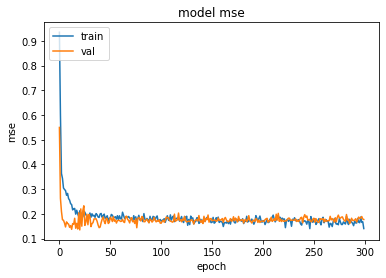

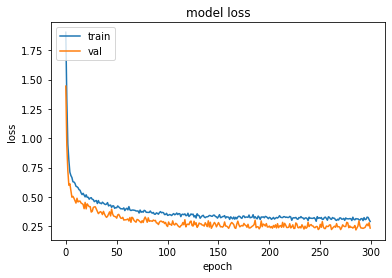



Training model 1 - (LPM2) 

Epoch 1/300
110/110 - 2s - loss: 1.8764 - mean_squared_error: 0.9465 - val_loss: 1.4141 - val_mean_squared_error: 0.5727
Epoch 2/300
110/110 - 1s - loss: 1.4304 - mean_squared_error: 0.8865 - val_loss: 1.1412 - val_mean_squared_error: 0.5954
Epoch 3/300
110/110 - 1s - loss: 1.1959 - mean_squared_error: 0.8708 - val_loss: 0.9678 - val_mean_squared_error: 0.5663
Epoch 4/300
110/110 - 1s - loss: 1.0681 - mean_squared_error: 0.8526 - val_loss: 0.8758 - val_mean_squared_error: 0.5659
Epoch 5/300
110/110 - 1s - loss: 0.9601 - mean_squared_error: 0.7986 - val_loss: 0.7970 - val_mean_squared_error: 0.5362
Epoch 6/300
110/110 - 1s - loss: 0.8437 - mean_squared_error: 0.6594 - val_loss: 0.6119 - val_mean_squared_error: 0.3583
Epoch 7/300
110/110 - 1s - loss: 0.7912 - mean_squared_error: 0.5999 - val_loss: 0.6569 - val_mean_squared_error: 0.3961
Epoch 8/300
110/110 - 1s - loss: 0.7664 - mean_squared_error: 0.5804 - val_loss: 0.5984 - val_mean_squared_error: 0.3376
Ep

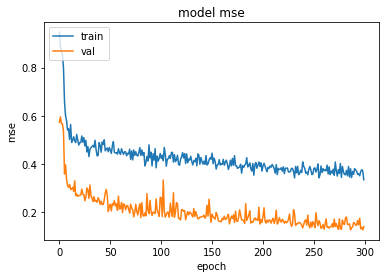

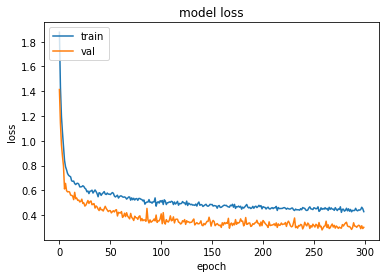



Training model 2 - (LPM4) 

Epoch 1/300
110/110 - 2s - loss: 1.8912 - mean_squared_error: 0.9026 - val_loss: 1.4543 - val_mean_squared_error: 0.5422
Epoch 2/300
110/110 - 1s - loss: 1.3705 - mean_squared_error: 0.7124 - val_loss: 1.0576 - val_mean_squared_error: 0.4811
Epoch 3/300
110/110 - 1s - loss: 1.1079 - mean_squared_error: 0.6451 - val_loss: 0.8780 - val_mean_squared_error: 0.4506
Epoch 4/300
110/110 - 1s - loss: 0.9678 - mean_squared_error: 0.6307 - val_loss: 0.7569 - val_mean_squared_error: 0.3813
Epoch 5/300
110/110 - 1s - loss: 0.8683 - mean_squared_error: 0.5790 - val_loss: 0.7249 - val_mean_squared_error: 0.4493
Epoch 6/300
110/110 - 1s - loss: 0.8355 - mean_squared_error: 0.6019 - val_loss: 0.6921 - val_mean_squared_error: 0.4224
Epoch 7/300
110/110 - 1s - loss: 0.7804 - mean_squared_error: 0.5594 - val_loss: 0.6731 - val_mean_squared_error: 0.4087
Epoch 8/300
110/110 - 1s - loss: 0.7724 - mean_squared_error: 0.5874 - val_loss: 0.6333 - val_mean_squared_error: 0.3939
Ep

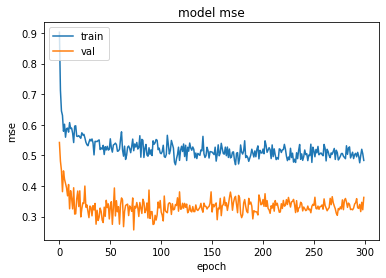

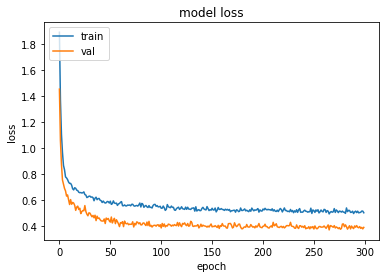

In [24]:
#train each model seperatly
#red_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_mean_squared_error", factor=0.1, patience=5, verbose=0, mode="auto", min_lr=0.001)
for n, model in enumerate(models):
    print(f"\n\nTraining model {n} - ({modes[n]}) \n")
    #history = model.fit(train[n][..., None], train_y[n], batch_size=64, epochs=50, verbose=0, validation_data=(val[n][..., None], val_y[n])) #-- Without gradient
    history = model.fit(train[n][..., None], train_y[n], batch_size=4, epochs=300, verbose=2, validation_data=(val[n][..., None], val_y[n]))#, callbacks=[red_lr]) #-- With gradient
    # list all data in history
    # summarize history for mean_squared_error
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('model mse')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [25]:
for mode in range(len(modes)):
    print(f"{modes[mode]} {models[mode].evaluate(test[mode][..., None], test_y[mode])}")

3/3 [==============================] - 0s 19ms/step - loss: 0.2292 - mean_squared_error: 0.1379
LPM0 [0.22916369140148163, 0.13794569671154022]
3/3 [==============================] - 0s 16ms/step - loss: 0.4252 - mean_squared_error: 0.3585
LPM2 [0.4251810312271118, 0.358545184135437]
3/3 [==============================] - 0s 18ms/step - loss: 0.4826 - mean_squared_error: 0.4261
LPM4 [0.48257988691329956, 0.42610692977905273]


In [27]:
for n, model in enumerate(models):
    model.save(f"models/model_{modes[n]}.h5")

In [29]:
#show some predictions from test dataset
start = 40
predictions = 10
for mode in range(len(modes)):
    print(f"\nPredicting {predictions} values - ({modes[mode]}) \n")
    for n in range(start, start+predictions):
        print(f"\tPredicted: {(models[mode](test[mode][n][None, ..., None]).numpy() * doses_std) + doses_mean}, expected: {(test_y[mode][n] * doses_std) + doses_mean}")


Predicting 10 values - (LPM0) 

	Predicted: [[20.607513]], expected: 21.76
	Predicted: [[46.75576]], expected: 48.96
	Predicted: [[50.8326]], expected: 54.4
	Predicted: [[0.99557686]], expected: 0.0
	Predicted: [[37.439938]], expected: 32.64
	Predicted: [[22.268661]], expected: 21.76
	Predicted: [[1.1840019]], expected: 0.0
	Predicted: [[49.333313]], expected: 27.2
	Predicted: [[1.3438683]], expected: 0.0
	Predicted: [[6.7124596]], expected: 5.440000000000001

Predicting 10 values - (LPM2) 

	Predicted: [[5.7759285]], expected: 21.76
	Predicted: [[43.332264]], expected: 48.96
	Predicted: [[48.914814]], expected: 54.4
	Predicted: [[2.4636993]], expected: 0.0
	Predicted: [[33.51822]], expected: 32.64
	Predicted: [[7.7577534]], expected: 21.76
	Predicted: [[8.308199]], expected: 0.0
	Predicted: [[27.276793]], expected: 27.2
	Predicted: [[4.2363605]], expected: 0.0
	Predicted: [[11.359213]], expected: 5.440000000000001

Predicting 10 values - (LPM4) 

	Predicted: [[28.589018]], expected: 